In [115]:
import csv
import datetime
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import numpy as np
import seaborn as sns
import pandas
from mpl_toolkits.mplot3d import Axes3D
from sklearn import preprocessing
from pyts.classification import BOSSVS
from pyts.datasets import load_gunpoint


In [116]:
#definições de funções
def clean_vector(vectors, target_length):
    cleaned_vectors = []
    seconds = vectors[0][0]
    sum_vector = [0,0,0]
    mean_vector = [0,0,0]
    counter = 0
    for vector in vectors:
        if vector[0] < 0:
            print(vector)
            continue
        if vector[0] != seconds:
            mean_vector = [sum_vector[0] / counter, sum_vector[1] / counter, sum_vector[2] / counter]
            cleaned_vectors.append([seconds, mean_vector[0],mean_vector[1],mean_vector[2]])
            counter = 0
            seconds = vector[0]
            sum_vector = [0,0,0]
        sum_vector = [sum_vector[0] + vector[1],sum_vector[1] + vector[2],sum_vector[2] + vector[3]]
        counter = counter + 1
    return cleaned_vectors

In [117]:
def magnitude_of_vectors(vectors):
    dot_product = []
    for vector in vectors:
        dot_product.append(np.linalg.norm(vector[1:]))
    return dot_product

In [118]:
def unify(vectors1, vectors2):
    unified = []
    for i in range(0, min(len(vectors1), len(vectors2))):
        unified.append((vectors1[i]+vectors2[i])/2)
    return unified

In [119]:
def remove_outlier(df, key, threshold):
    df = df[(np.abs((df[key] - df[key].mean())/df[key].std(ddof=0)) < threshold)]
    df.index = range(0, len(df.time))
    return df

In [120]:
def plot_graph_v(vectordf, titulo):
    plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
    fig, ax1 = plt.subplots()
    fig.set_figheight(6)
    fig.set_figwidth(18)
    ax1.plot(vectordf.time, vectordf.x, label='x')
    ax1.plot(vectordf.time, vectordf.y, label='y')
    ax1.plot(vectordf.time, vectordf.z, label='z')
    ax2 = ax1.twinx()
    ax2.set_ylabel('Frequencia (s)', color='tab:red')
    ax2.plot(df_buxco.time[0:], df_buxco.frequency[0:], label='frequencia', color='tab:red')
    ax1.set_title(titulo)
    ax1.set_xlabel('Tempo (s)')
    ax1.legend(loc=2)
    ax2.legend(loc=1)
    fig.savefig(titulo + '.png')

In [121]:
def plot_graph_m(vectordf, titulo):
    fig, ax1 = plt.subplots()
    plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
    fig.set_figheight(6)
    fig.set_figwidth(18)
    ax1.plot(vectordf.time, vectordf.magnitude, label='magnitude')
    ax1.set_title(titulo)
    ax1.set_xlabel('Tempo (s)')
    ax2 = ax1.twinx()
    ax2.set_ylabel('Frequencia', color='tab:orange')
    ax2.plot(df_buxco.time[0:], df_buxco.frequency[0:], label='frequency', color='tab:orange')
    ax1.legend(loc=2)
    ax2.legend(loc=1)
    fig.savefig(titulo + '.png')

In [122]:
def normalize(df, columns):
    for column in columns:
        df[column]=(df[column]-df[column].min())/(df[column].max()-df[column].min())
    return df

In [123]:
def normalize_preprocessing(df, columns):
    for column in columns:
        x = [df[column]]
        normalized = preprocessing.normalize(x)
        df[column] = normalized[0]
    return df

In [124]:
def read_signa_csv():
    df = pandas.read_csv('rato1-signa-test.csv')
    df['time'] = pandas.to_datetime(df['time'], format="%Y-%m-%d %H:%M:%S.%f")
    df['time'] = df['time'] - df['time'][0]
    df['time'] = df['time'].dt.total_seconds()
    return df


In [125]:
def read_buxco_csv():
    df_buxco = pandas.read_csv('buxco.csv')
    df_buxco['time'] = df_buxco.ti+df_buxco.te+((df_buxco.eip + 107.36)/1000)
    df_buxco['time'] = df_buxco.time.cumsum()
    return df_buxco

In [126]:
def get_sensors(df):
    temperature = []
    axis = []
    rest = []
    ax = []
    df.sort_values(by=['time'], inplace=True)
    for index, data in df.iterrows():
        if float(data['x']) == 0 and float(data['y']) == 0 and float(data['z']) == 0 and float(data['temperature']) == 0:
            rest.append(data)
        elif float(data['x']) == 0 and float(data['y']) == 0 and float(data['z']) == 0 and float(data['temperature']) != 0:
            temperature.append([data['time'], data['sensor_id'],data['temperature']])
        else:
            z = data['z']
            if isinstance(data['z'], str):
                z = data['z'].replace(' ','')
            if np.isnan(float(z)):
                continue
            ax.append([data['time'], data['sensor_id'],data['x'],data['y'],data['z']])
            axis.append([data['time'], data['sensor_id'],float(data['x']),float(data['y']),float(z)])
    axis = pandas.DataFrame(axis, columns=['time', 'sensor_id', 'x', 'y', 'z'])
    vectors_30 = []
    vectors_105 = []
    vectors_29 = []
    last_time = 0
    for index,row in axis.iterrows():
        if(row.time < 0 or row.time > 700):
            continue
        try:
            if(row.sensor_id == 29.0):
                vectors_29.append([row.time, row.x,row.y,float(row.z)])
            if(row.sensor_id == 30.0):
                vectors_30.append([row.time, row.x,row.y,float(row.z)])
            if(row.sensor_id == 105.0):
                vectors_105.append([row.time, row.x,row.y,float(row.z)])
        except:
            print(row)
        last_time = row.time
            
    return vectors_29, vectors_30, vectors_105

In [127]:
def get_magnitude(df):
    return magnitude_of_vectors(zip(df.x,df.y,df.z))

In [128]:
def unify_sensors(s_29, s_30, s_105):
    return unify(unify(s_29.magnitude, s_30.magnitude), s_105.magnitude)

In [129]:
def plot_buxco(df):
    fig, axs = plt.subplots(7, figsize=(15, 50))
    axs[0].plot(df.index.values[0:], df.frequency[0:])
    axs[1].plot(df.index.values[0:], df.penh[0:])
    axs[2].plot(df.index.values[0:], df.rt[0:])
    axs[3].plot(df.index.values[0:], df.mv[0:])
    axs[4].plot(df.index.values[0:], df.ti[0:])
    axs[5].plot(df.index.values[0:], df.te[0:])
    axs[6].plot(df.index.values[0:], df.eip[0:])
    axs[0].set_title("FREQUÊNCIA RESPIRATÓRIA")
    axs[0].set_xlabel("eventos")
    axs[1].set_title("PenH")
    axs[1].set_xlabel("eventos")
    axs[2].set_title("TEMPO DE RELAXAMENTO")
    axs[2].set_xlabel("eventos")
    axs[3].set_title("VOLUME MINUTO")
    axs[3].set_xlabel("eventos")
    plt.savefig('graficos.png')

In [130]:
def remove_sensor_outlier(df, threshold):
    df = remove_outlier(df, 'x', threshold)
    df = remove_outlier(df, 'y', threshold)
    df = remove_outlier(df, 'z', threshold)
    return df

In [131]:
def get_magnitude(df):
    df['magnitude'] = magnitude_of_vectors(zip(df.x, df.y,df.z))
    return df

In [132]:
def plot_points(df):
    fig = plt.figure(num=None, figsize=(18, 18), dpi=80, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(df.x, df.y, df.z, c='r', marker='o')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')


    plt.show()

In [133]:
def plot_corr(data, features, title='title'):
    correlation_mat = pandas.DataFrame(data, columns=features).corr()
    sns.heatmap(correlation_mat, annot = True, vmin = -1, vmax = 1)
    plt.title(title)
    plt.show()

In [134]:
####fim definições de funções

df = read_signa_csv()
df_buxco = read_buxco_csv()
vectors_29, vectors_30, vectors_105 = get_sensors(df)


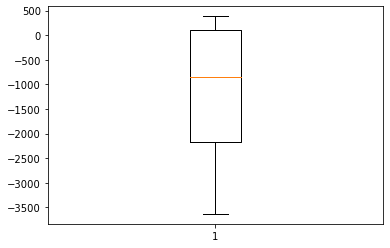

In [136]:
sensor_29 = pandas.DataFrame(vectors_29, columns=['time', 'x', 'y', 'z'])
sensor_29['magnitude'] = get_magnitude(sensor_29)

sensor_30 = pandas.DataFrame(vectors_30, columns=['time', 'x', 'y', 'z'])
sensor_30['magnitude'] = get_magnitude(sensor_30)

sensor_105 = pandas.DataFrame(vectors_105, columns=['time', 'x', 'y', 'z'])
sensor_105['magnitude'] = get_magnitude(sensor_105)


mean_mag = pandas.DataFrame(zip(sensor_105.time,unify_sensors(sensor_29, sensor_30, sensor_105)), columns=['time', 'magnitude'])


mean_mag.to_csv('csvs/1-magnitude media.csv')
sensor_29.to_csv('csvs/1-sensor 29.csv')
sensor_30.to_csv('csvs/1-sensor 30.csv')
sensor_105.to_csv('csvs/1-sensor 105.csv')

sensor_29 = remove_sensor_outlier(sensor_29, 3)
sensor_30 = remove_sensor_outlier(sensor_30, 3)
sensor_105 = remove_sensor_outlier(sensor_105, 3)

sensor_29 = get_magnitude(sensor_29)
sensor_30 = get_magnitude(sensor_30)
sensor_105 = get_magnitude(sensor_105)

mean_mag = pandas.DataFrame(zip(sensor_105.time, unify_sensors(sensor_29, sensor_30, sensor_105)), columns=['time', 'magnitude'])

mean_mag.to_csv('csvs/2-magnitude media.csv')
sensor_29.to_csv('csvs/2-sensor 29.csv')
sensor_30.to_csv('csvs/2-sensor 30.csv')
sensor_105.to_csv('csvs/2-sensor 105.csv')

{'whiskers': [<matplotlib.lines.Line2D at 0x19b8f46ed00>,
 'caps': [<matplotlib.lines.Line2D at 0x19b8f481b20>,
 'boxes': [<matplotlib.lines.Line2D at 0x19b8f461fa0>],
 'medians': [<matplotlib.lines.Line2D at 0x19b8f44ed00>],
 'fliers': [<matplotlib.lines.Line2D at 0x19b8f4a02e0>],
 'means': []}

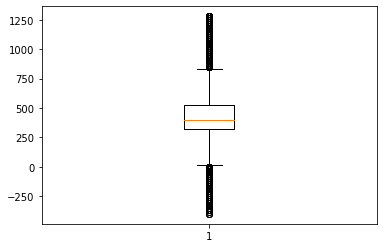

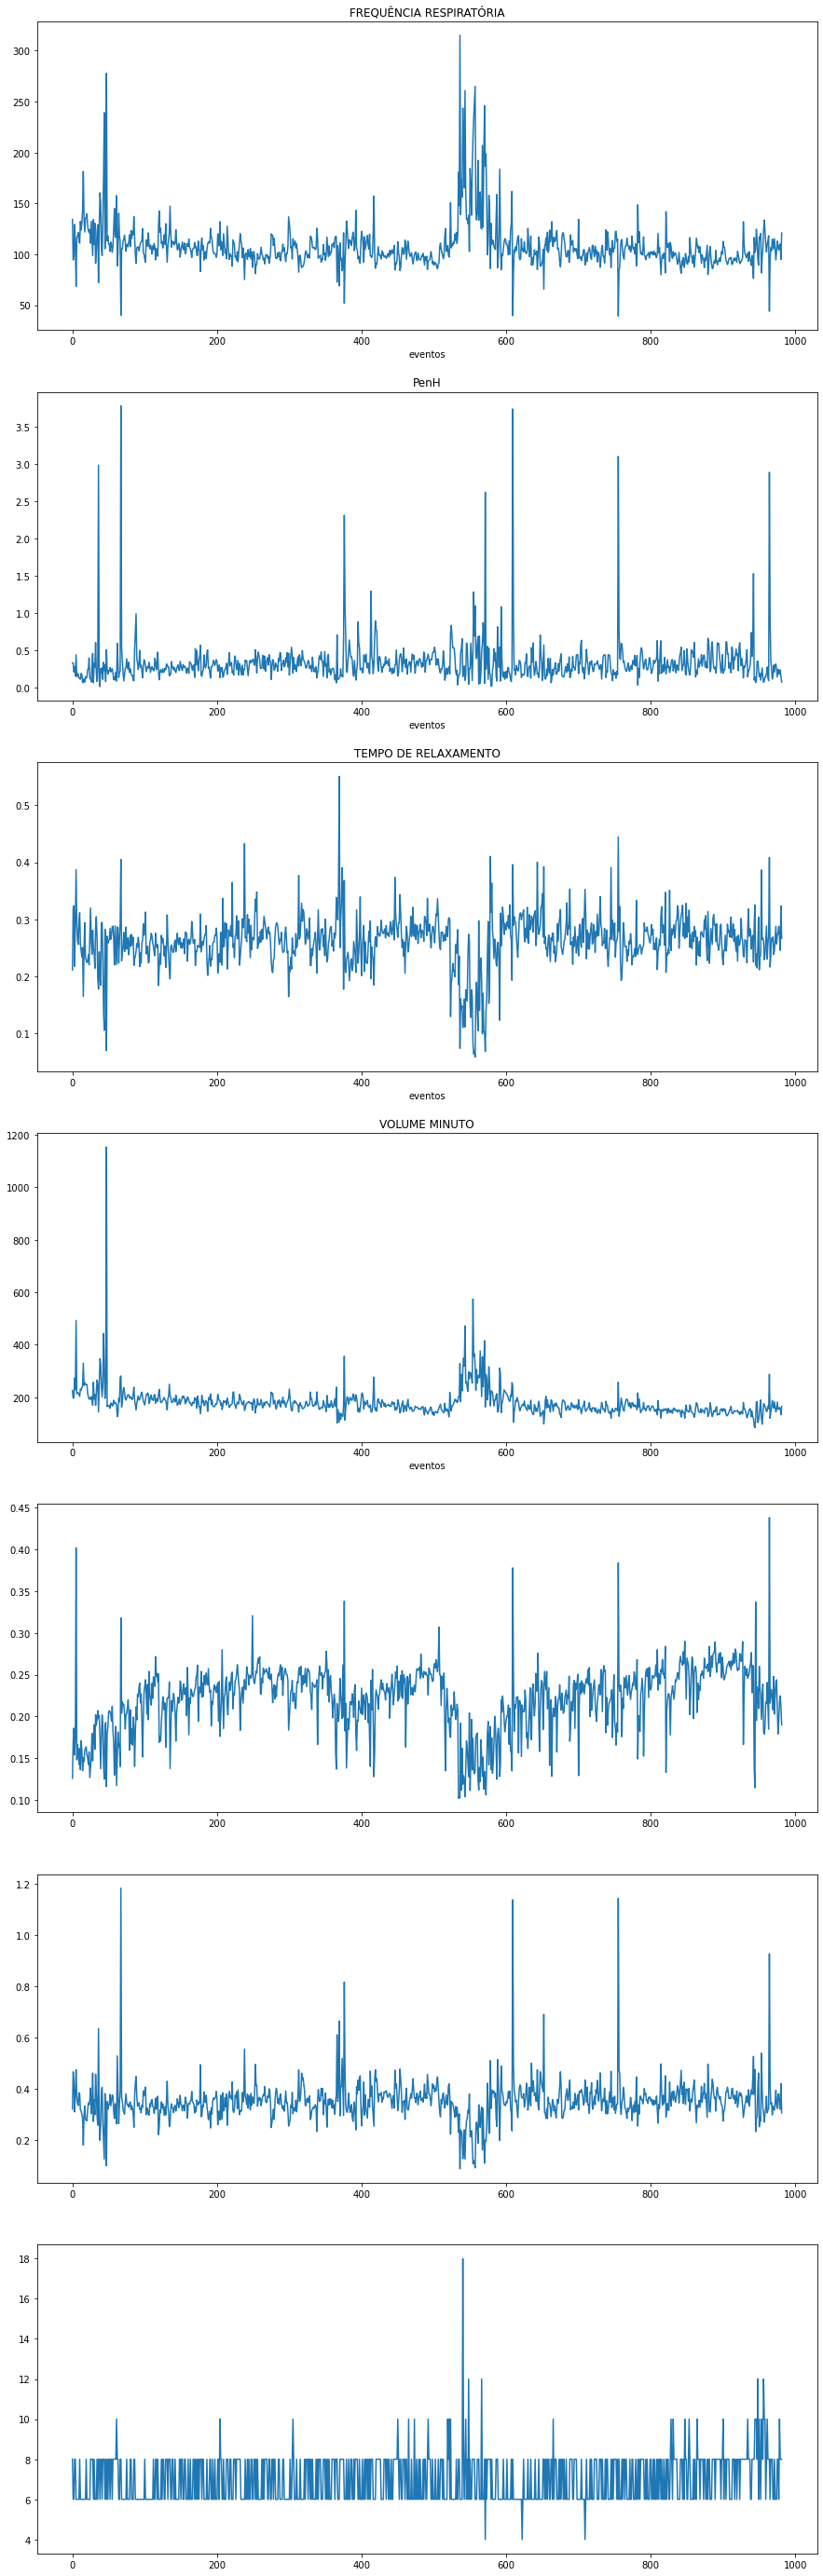

In [138]:
plot_buxco(df_buxco)

<Figure size 1440x480 with 0 Axes>

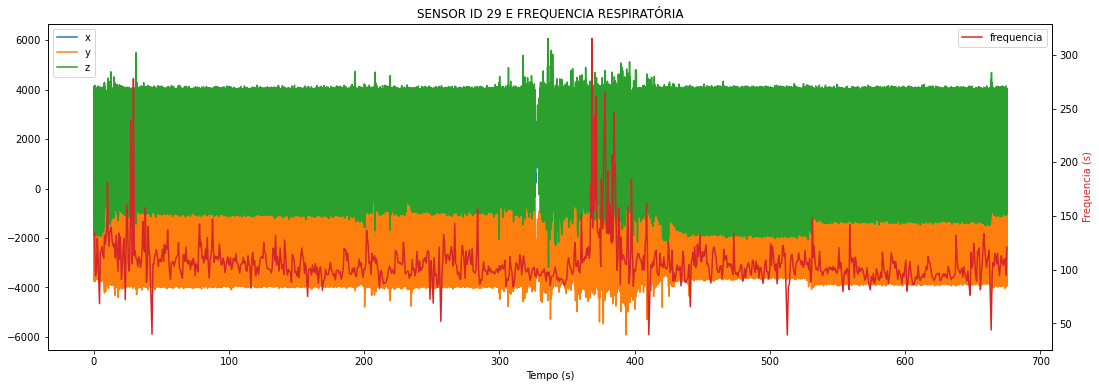

<Figure size 1440x480 with 0 Axes>

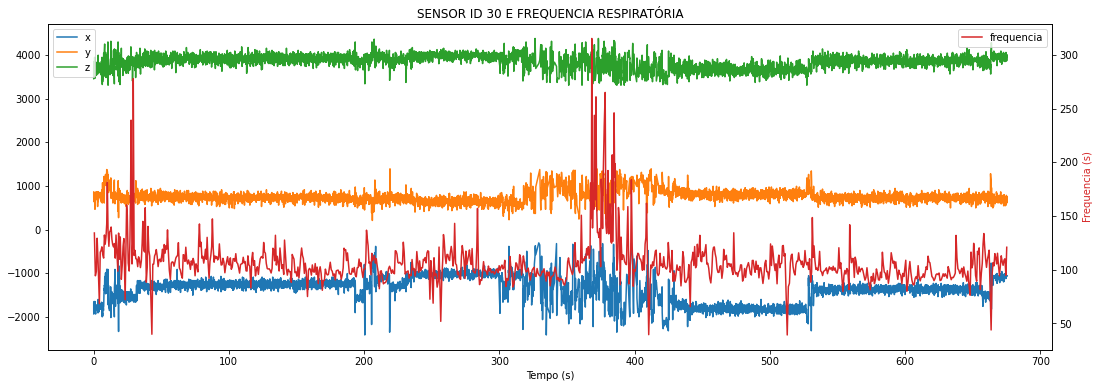

<Figure size 1440x480 with 0 Axes>

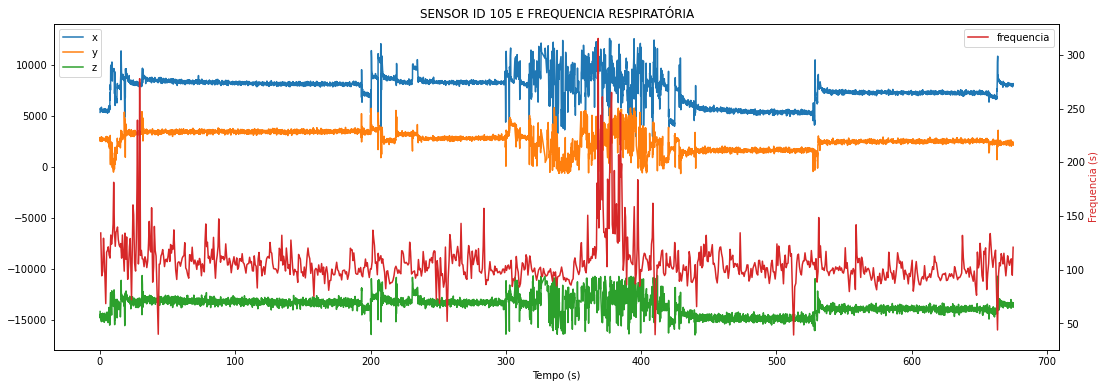

In [139]:
plot_graph_v(sensor_29, "SENSOR ID 29 E FREQUENCIA RESPIRATÓRIA")
plot_graph_v(sensor_30, "SENSOR ID 30 E FREQUENCIA RESPIRATÓRIA")
plot_graph_v(sensor_105, "SENSOR ID 105 E FREQUENCIA RESPIRATÓRIA")

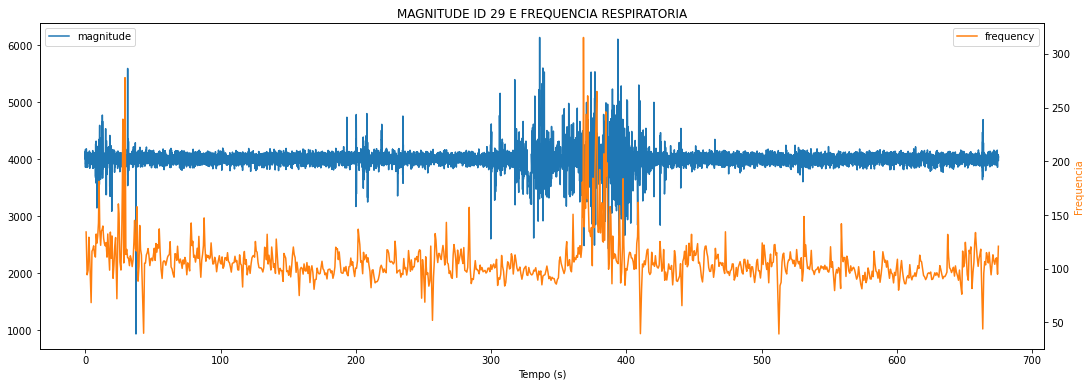

<Figure size 1440x480 with 0 Axes>

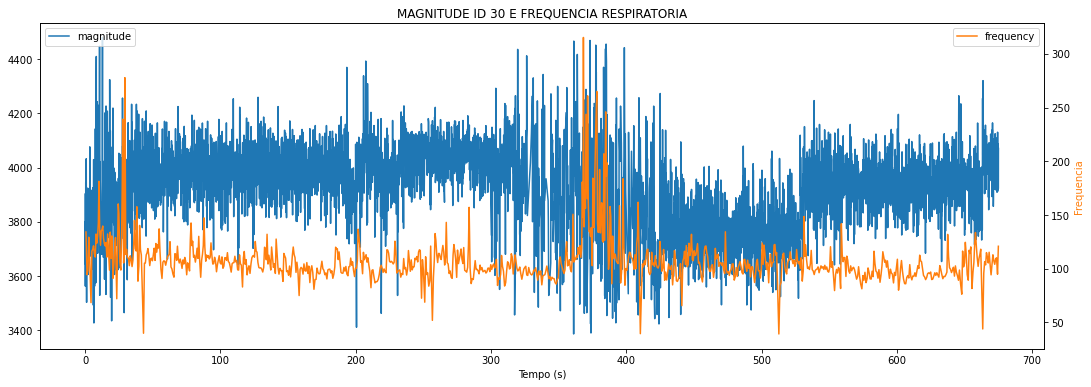

<Figure size 1440x480 with 0 Axes>

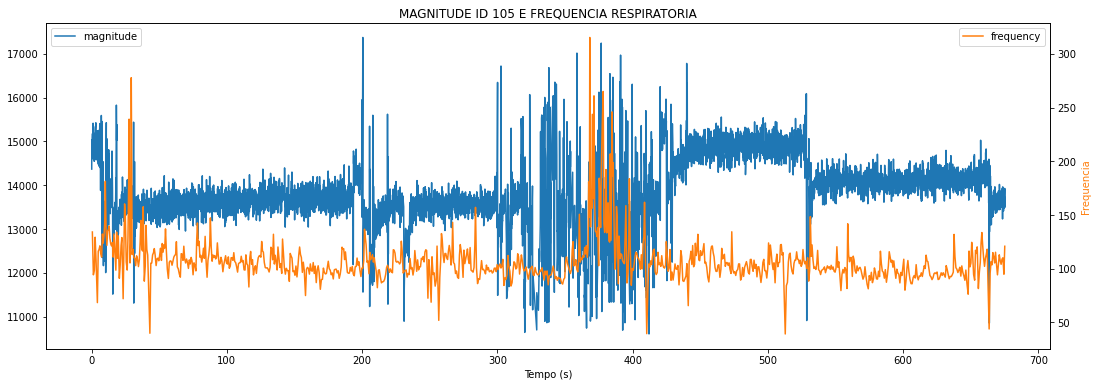

<Figure size 1440x480 with 0 Axes>

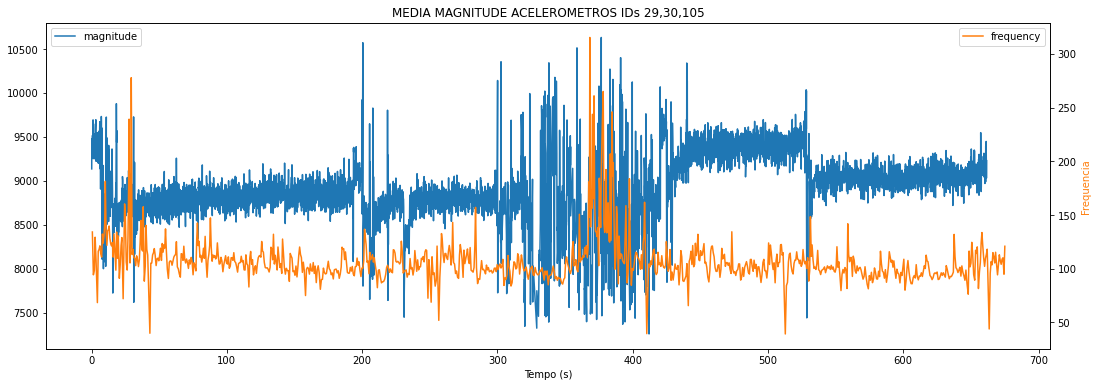

<Figure size 1440x480 with 0 Axes>

In [140]:
plot_graph_m(sensor_29, "MAGNITUDE ID 29 E FREQUENCIA RESPIRATORIA")
plot_graph_m(sensor_30, "MAGNITUDE ID 30 E FREQUENCIA RESPIRATORIA")
plot_graph_m(sensor_105, "MAGNITUDE ID 105 E FREQUENCIA RESPIRATORIA")
plot_graph_m(mean_mag, "MEDIA MAGNITUDE ACELEROMETROS IDs 29,30,105")

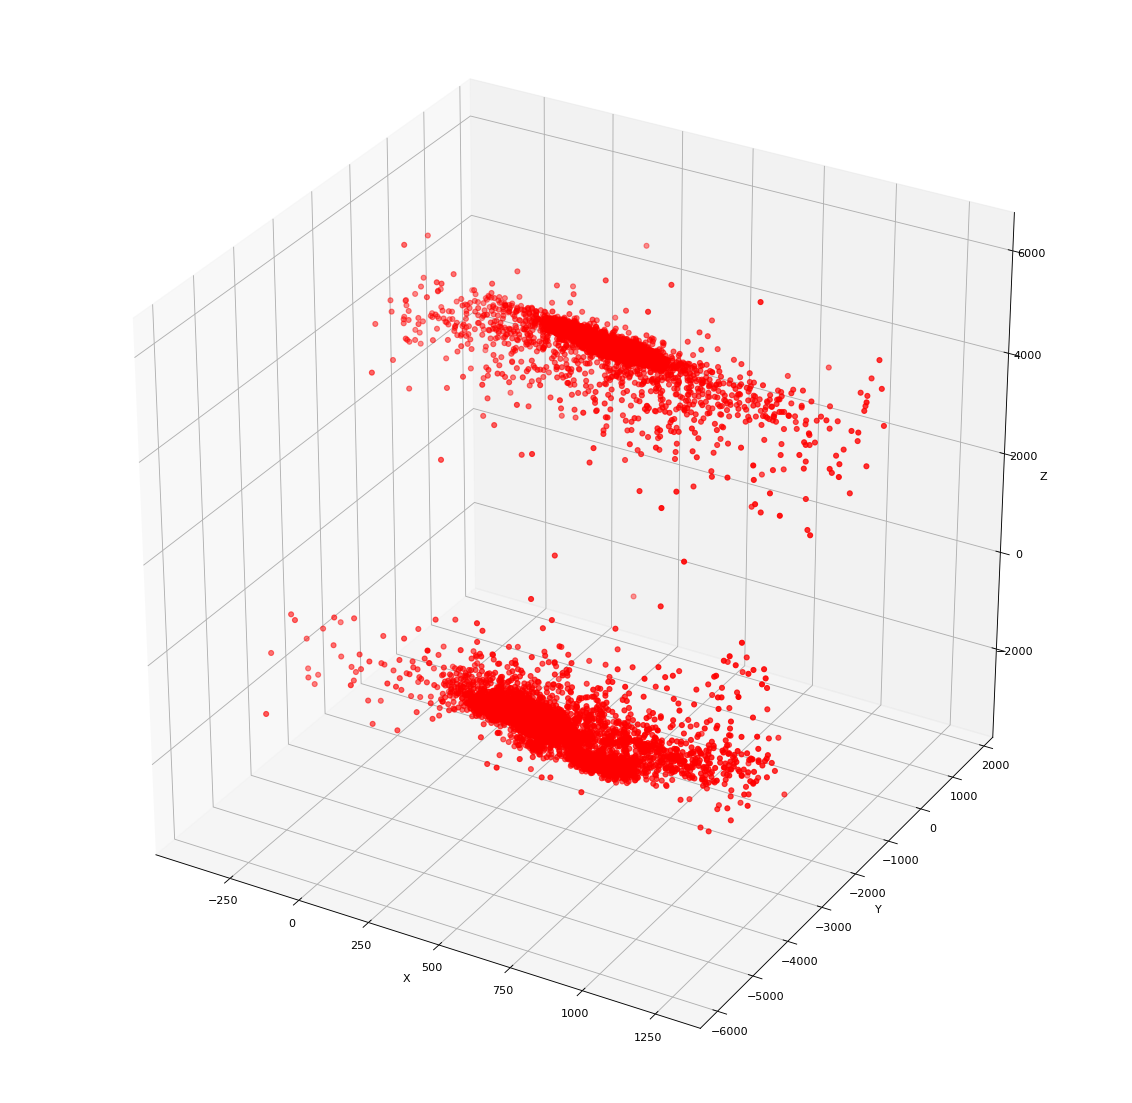

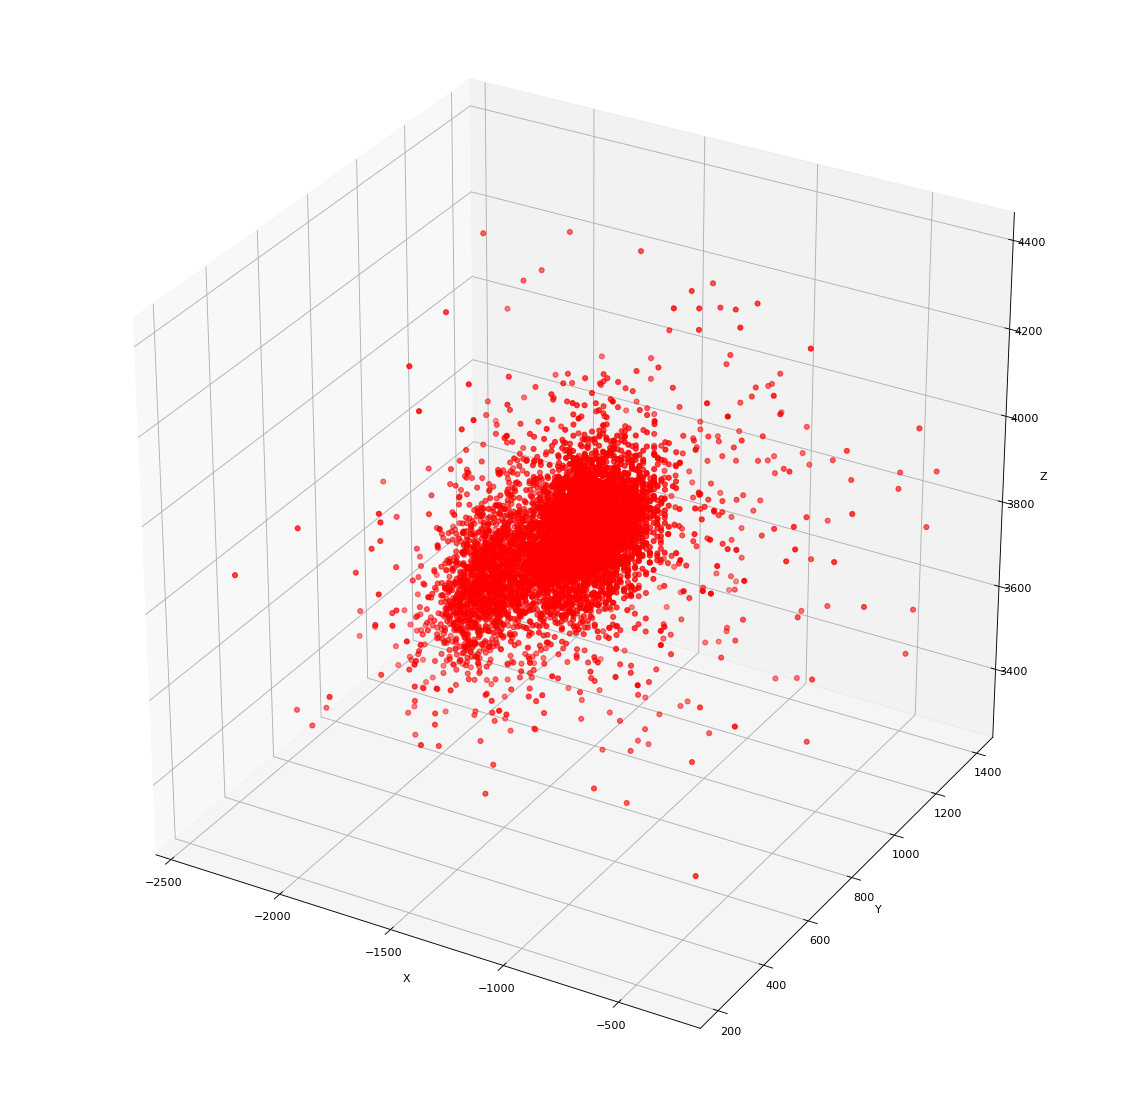

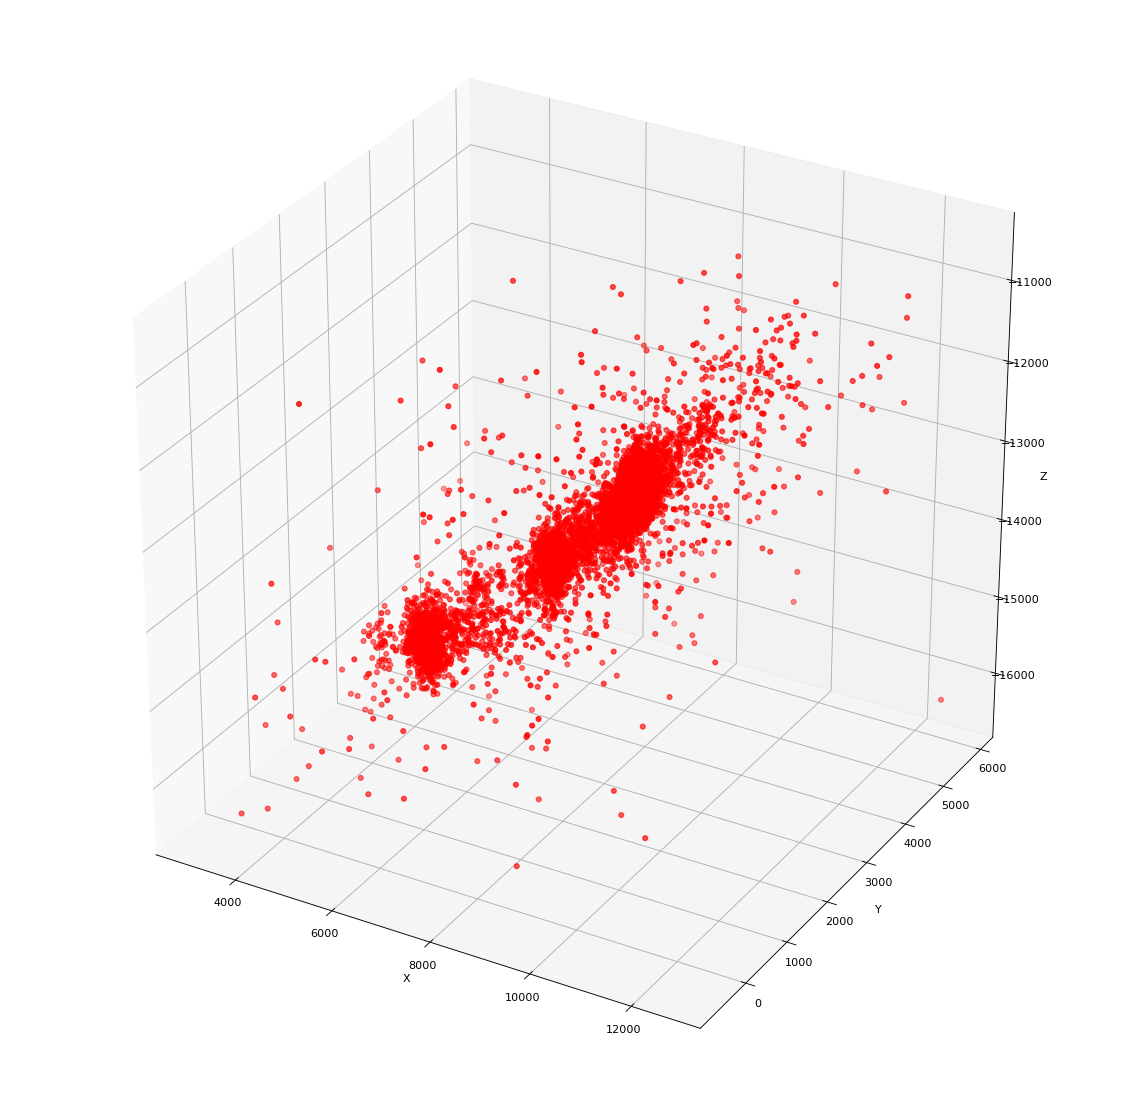

In [141]:
plot_points(sensor_29)
plot_points(sensor_30)
plot_points(sensor_105)


In [142]:
#Normalização dos dados
normalize(sensor_29, ['x', 'y', 'z', 'magnitude'])#muda o dataframe inplace
normalize(sensor_30, ['x', 'y', 'z', 'magnitude'])
normalize(sensor_105, ['x', 'y', 'z', 'magnitude'])
normalize(df_buxco, ['frequency'])

,frequency,penh,rt,mv,te,ti,eip,time
0,0.343961,0.331564,0.210798,225.829210,0.321070,0.126000,8,0.562430
1,0.199589,0.328262,0.318040,196.099875,0.465995,0.169742,6,1.311527
2,0.215120,0.210667,0.323635,200.527395,0.422123,0.186005,6,2.033015
3,0.326296,0.277827,0.217341,272.539841,0.309916,0.154000,8,2.612290
4,0.250003,0.157493,0.292707,228.587323,0.380000,0.174085,8,3.281735
...,...,...,...,...,...,...,...,...
977,0.234944,0.224645,0.287628,155.336661,0.380883,0.195308,6,672.380480
978,0.252501,0.178785,0.269585,161.238496,0.333465,0.217117,10,673.048421
979,0.256887,0.238015,0.245207,157.182799,0.320000,0.224535,8,673.708317
980,0.201555,0.143052,0.323423,133.429881,0.420104,0.212000,8,674.455780


In [143]:
def plot(sensor):
    fig, ax1 = plt.subplots()
    plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
    fig.set_figheight(6)
    fig.set_figwidth(18)

    ax1.plot(sensor.time, sensor.magnitude, label='magnitude')
    ax1.plot(sensor.time, sensor.x, label='x')
    ax1.plot(sensor.time, sensor.y, label='y')
    ax1.plot(sensor.time, sensor.z, label='z')
    ax1.plot(df_buxco.time, df_buxco.frequency, label='frequencia')
    ax1.set_title("Acelerometro, magnitude e frequencia respiratoria")
    ax1.set_xlabel('Tempo (s)')
    ax1.legend(loc=2)

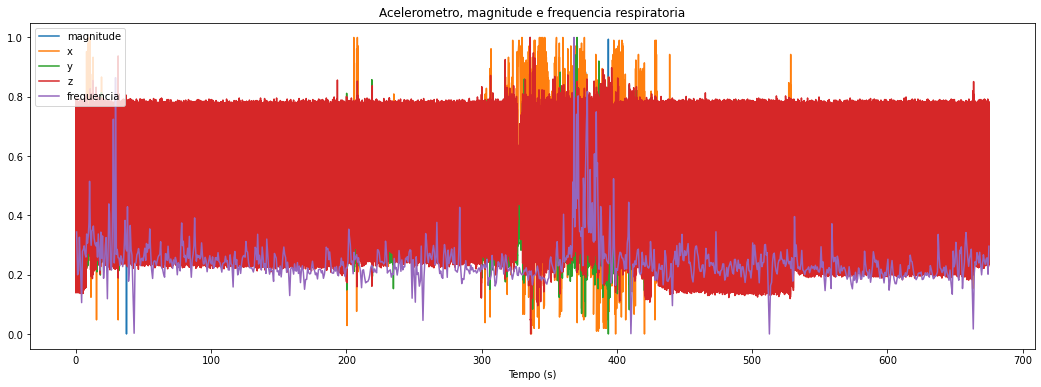

<Figure size 1440x480 with 0 Axes>

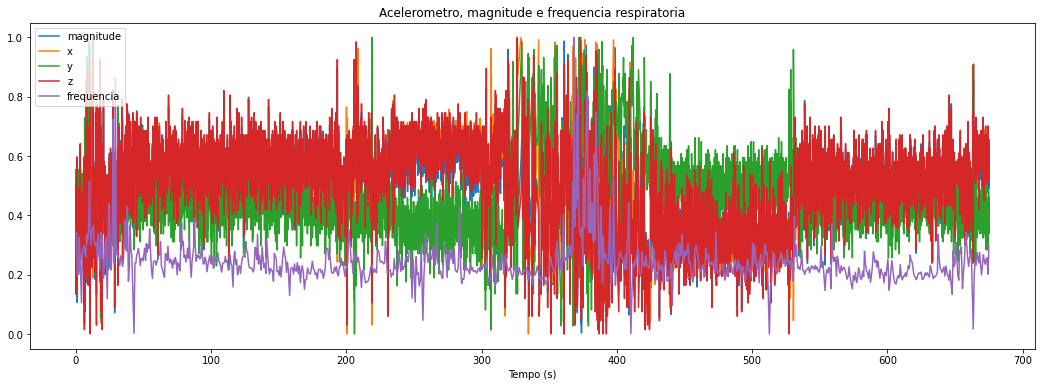

<Figure size 1440x480 with 0 Axes>

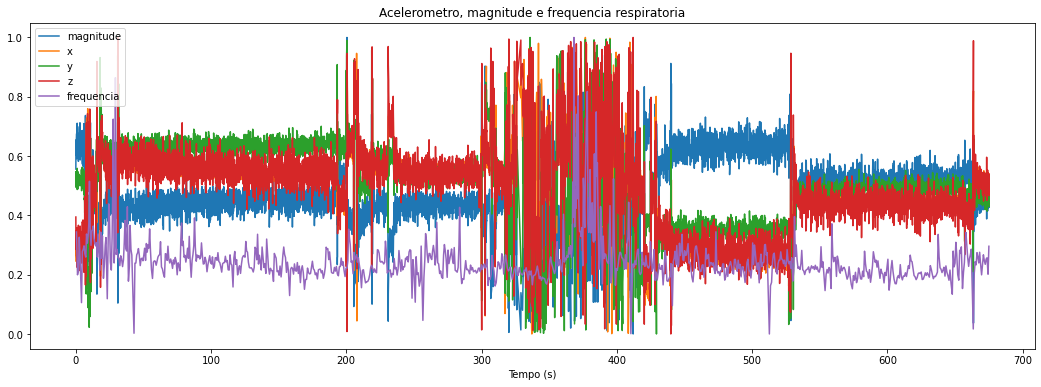

<Figure size 1440x480 with 0 Axes>

In [144]:
#plot dos dados normaizados
plot(sensor_29)
plot(sensor_30)
plot(sensor_105)

In [145]:
def approximate_data(df, target):
    mag = df
    fake_dex = 0
    mag_sum = 0
    mag_quantity = 0
    result = []
    for index, data in mag.iterrows():
        if data[0] > target.time[fake_dex]:
            result.append(mag_sum/mag_quantity)
            fake_dex += 1
            mag_sum = 0
            mag_quantity = 0
            if(fake_dex >= len(target.time)):
                break
        mag_sum += data.magnitude
        mag_quantity += 1
    return result

In [146]:
#reduzindo o tamanho do dataset
processed_sensor_29 = approximate_data(sensor_29, df_buxco)
processed_sensor_30 = approximate_data(sensor_30, df_buxco)
processed_sensor_105 = approximate_data(sensor_105, df_buxco)

In [147]:
def plot_processed_data(data, title='title'):
    plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(df_buxco.time, data, label='x')
    plt.plot(df_buxco.time, df_buxco.frequency, label='s')
    plt.title(title)
    plt.savefig(title+'.png')

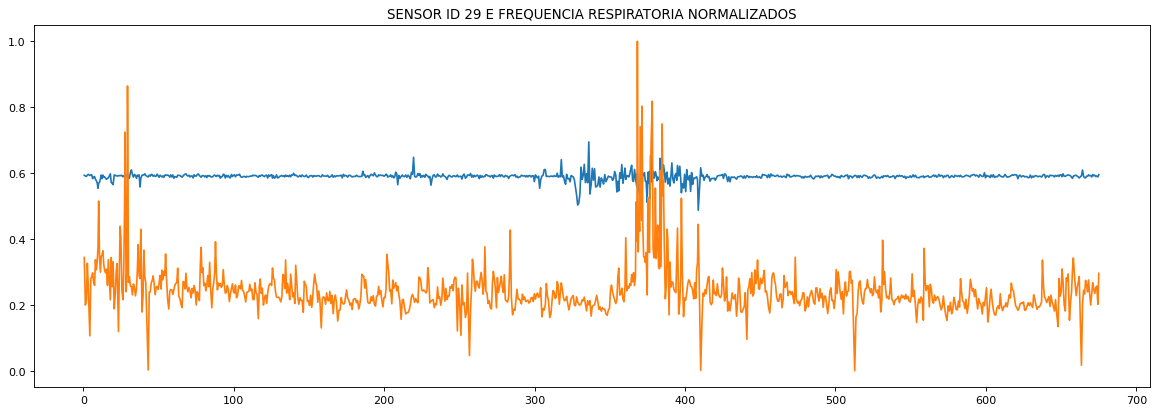

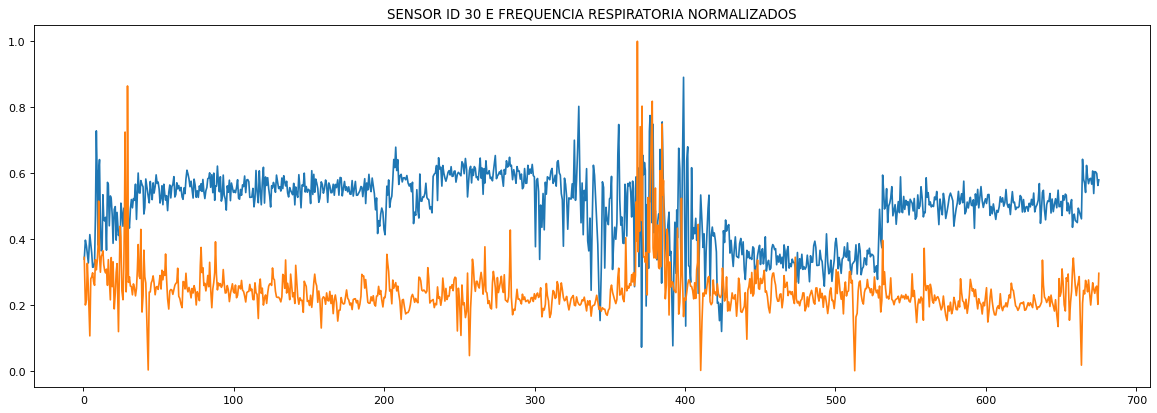

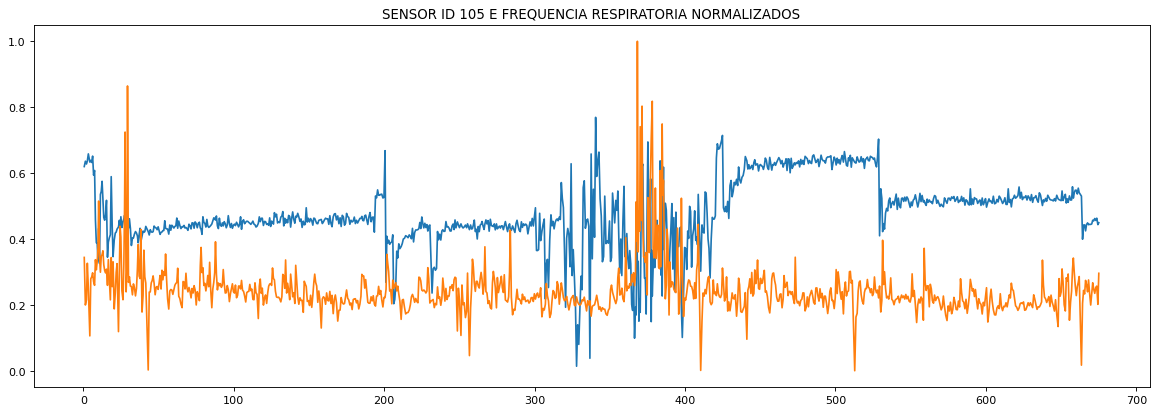

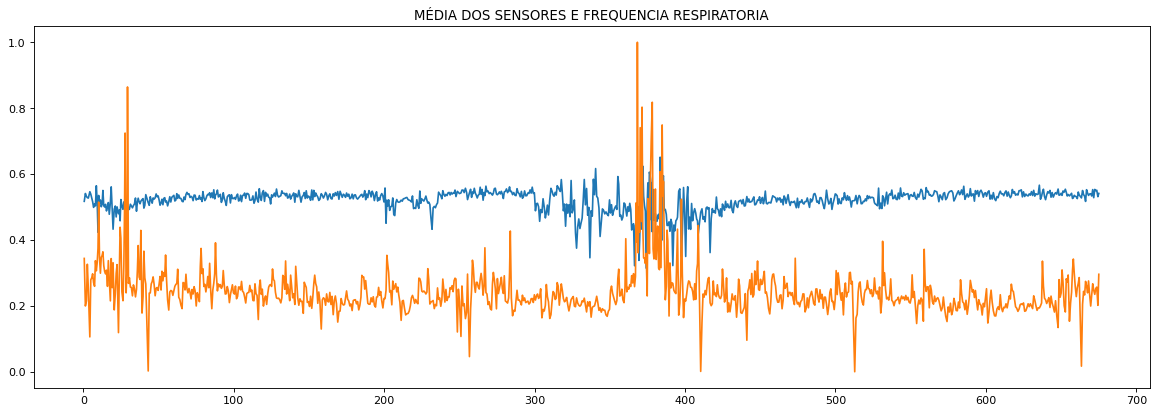

In [148]:
processed_sensors_mean = (np.array(processed_sensor_29) + np.array(processed_sensor_30) + np.array(processed_sensor_105))/np.float(3)
plot_processed_data(processed_sensor_29, "SENSOR ID 29 E FREQUENCIA RESPIRATORIA NORMALIZADOS")
plot_processed_data(processed_sensor_30, "SENSOR ID 30 E FREQUENCIA RESPIRATORIA NORMALIZADOS")
plot_processed_data(processed_sensor_105, "SENSOR ID 105 E FREQUENCIA RESPIRATORIA NORMALIZADOS")
plot_processed_data(processed_sensors_mean, "MÉDIA DOS SENSORES E FREQUENCIA RESPIRATORIA")

In [149]:
def plot_scatter(data1, data2, title="title"):
    plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.scatter(data1, data2,c='r', marker='o')
    plt.title(title)

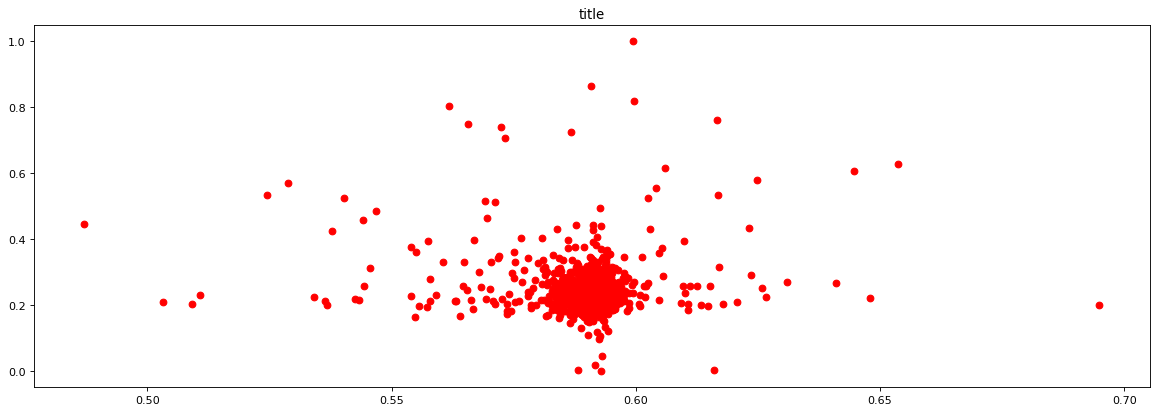

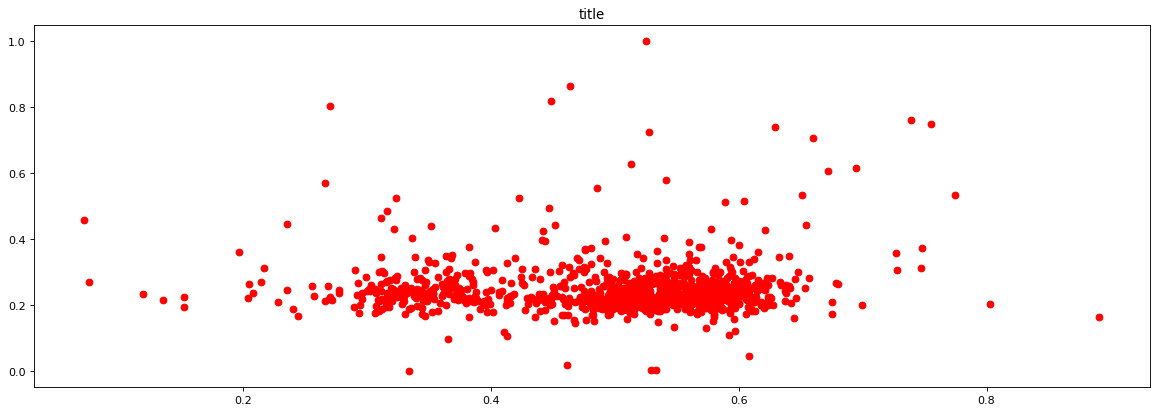

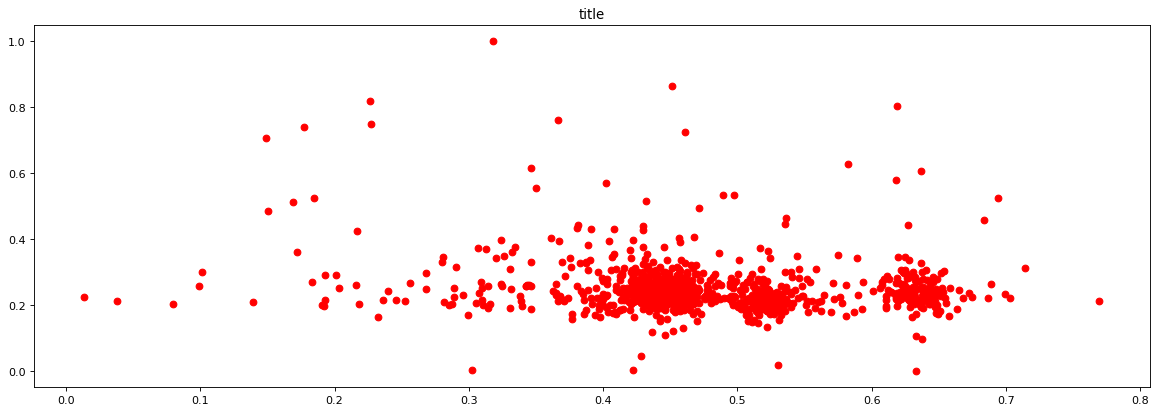

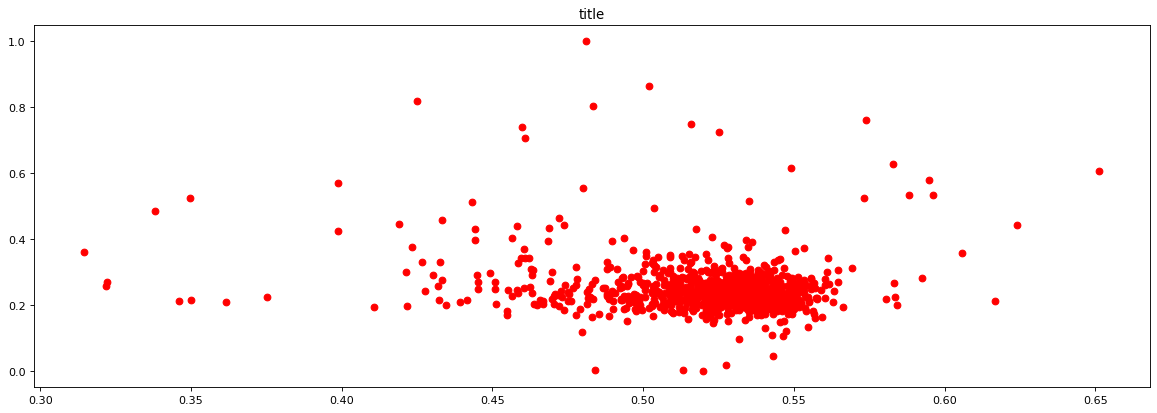

In [150]:
plot_scatter(processed_sensor_29, df_buxco.frequency)
plot_scatter(processed_sensor_30, df_buxco.frequency)
plot_scatter(processed_sensor_105, df_buxco.frequency)
plot_scatter(processed_sensors_mean, df_buxco.frequency)

In [151]:
def get_covar(a):
    return pandas.DataFrame(zip(a, df_buxco.frequency), columns=['sensor', 'frequencia']).cov()


In [152]:
get_covar(processed_sensor_29)

,sensor,frequencia
sensor,0.000152,-0.000065
frequencia,-0.000065,0.006856


In [153]:
get_covar(processed_sensor_30)


,sensor,frequencia
sensor,0.011160,0.000221
frequencia,0.000221,0.006856


In [154]:
get_covar(processed_sensor_105)


,sensor,frequencia
sensor,0.010138,-0.001418
frequencia,-0.001418,0.006856


In [155]:
get_covar(processed_sensors_mean)

,sensor,frequencia
sensor,0.001090,-0.000421
frequencia,-0.000421,0.006856


In [156]:
import statistics

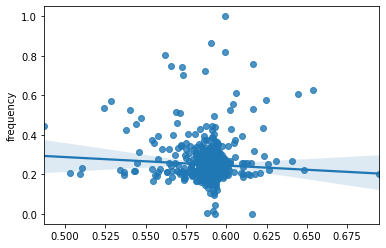

In [157]:
import seaborn as sns

sns.regplot(processed_sensor_29,df_buxco.frequency)

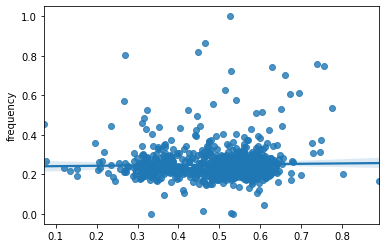

In [158]:
sns.regplot(processed_sensor_30,df_buxco.frequency)

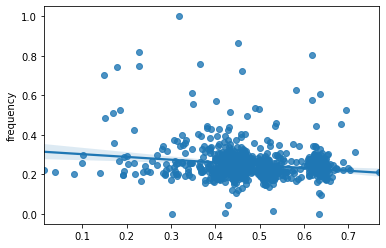

In [159]:
sns.regplot(processed_sensor_105,df_buxco.frequency)

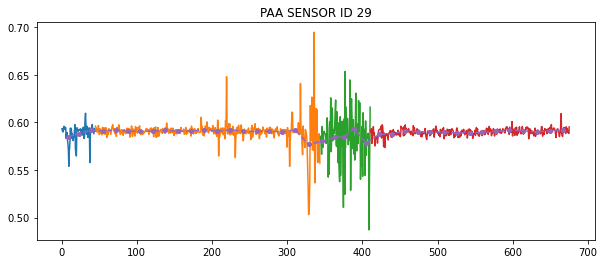

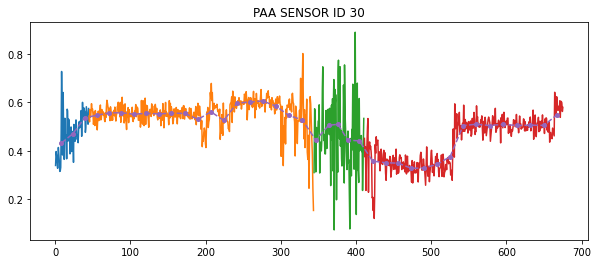

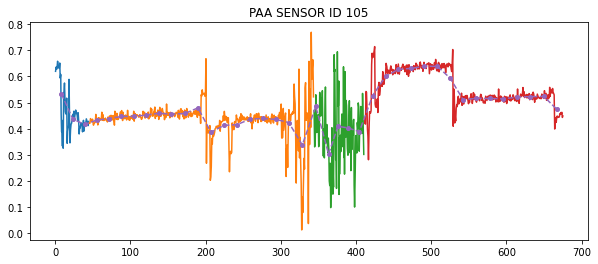

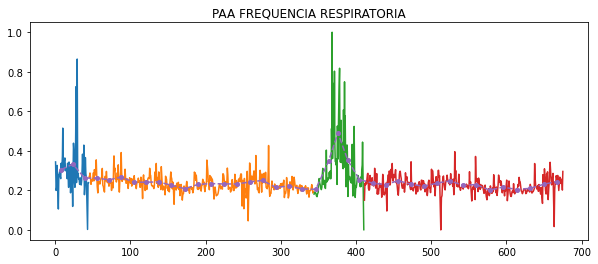

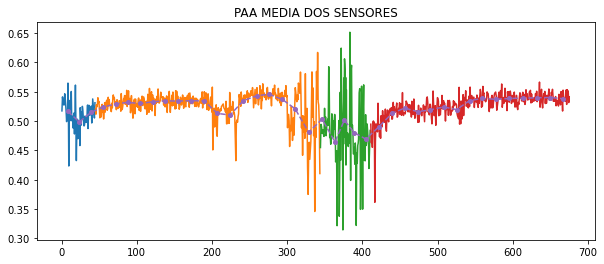

In [160]:
from pyts.approximation import PiecewiseAggregateApproximation
def fit(sensor, title='title'):
    X = np.array([np.array(sensor), np.array(df_buxco.time)])

    # PAA transformation
    window_size = 25 #50
    paa = PiecewiseAggregateApproximation(window_size=window_size)
    X_paa = paa.transform(X)

    # Show the results for the first time series
    plt.figure(figsize=(10, 4))
    plt.plot(X[1][0:70], X[0][0:70], ms=4)
    plt.plot(X[1][70:500], X[0][70:500], ms=4)
    plt.plot(X[1][500:610], X[0][500:610], ms=4)
    plt.plot(X[1][610:], X[0][610:], ms=4)
    plt.plot(X_paa[1], X_paa[0], 'o--', ms=4, label='PAA')
    #plt.vlines(np.arange(0, n_timestamps, window_size) - 0.5,
    #           X[0].min(), X[0].max(), color='g', linestyles='--', linewidth=0.5)
    #plt.legend(loc='best', fontsize=10)
    #plt.xlabel('Time', fontsize=12)
    #plt.title('Piecewise Aggregate Approximation', fontsize=16)
    plt.title(title)
    plt.savefig(title + '.png')
    plt.show()
    
    return X_paa

def get_normalized(series_before):
    return pandas.Series(series_before)
    #return (series-series.min())/(series.max()-series.min())
#timeseries = sensor_29.magnitude
#(timeseries-timeseries.min())/(timeseries.max()-timeseries.min())
series_29 = pandas.Series(processed_sensor_29)
paa_29 = fit(processed_sensor_29, "PAA SENSOR ID 29")
paa_30 = fit(processed_sensor_30, "PAA SENSOR ID 30")
paa_105 = fit(processed_sensor_105, "PAA SENSOR ID 105")
paa_buxco = fit(df_buxco.frequency, "PAA FREQUENCIA RESPIRATORIA")
paa_media = fit(processed_sensors_mean, "PAA MEDIA DOS SENSORES")


In [161]:
pandas.DataFrame(zip(paa_29[0],paa_buxco[0]), columns = ['magnitude','frequencia']).cov()

,magnitude,frequencia
magnitude,0.000014,-0.000032
frequencia,-0.000032,0.002808


In [162]:
pandas.DataFrame(zip(paa_30[0],paa_buxco[0]), columns = ['magnitude','frequencia']).cov()

,magnitude,frequencia
magnitude,0.006491,-0.000139
frequencia,-0.000139,0.002808


In [163]:
pandas.DataFrame(zip(paa_105[0],paa_buxco[0]), columns = ['magnitude','frequencia']).cov()

,magnitude,frequencia
magnitude,0.006347,-0.001337
frequencia,-0.001337,0.002808


In [164]:
pandas.DataFrame(zip(paa_media[0],paa_buxco[0]), columns = ['magnitude','frequencia']).cov()

,magnitude,frequencia
magnitude,0.000427,-0.000502
frequencia,-0.000502,0.002808


In [165]:
pandas.DataFrame(zip(df_buxco.time, df_buxco.frequency, processed_sensors_mean), columns=['time', 'frequency', 'sensor']).to_csv('result.csv')

In [166]:
np.corrcoef(df_buxco.frequency, processed_sensors_mean)

array([[ 1.        , -0.15384006],
       [-0.15384006,  1.        ]])

In [167]:
np.corrcoef(paa_buxco[0], paa_media[0])

array([[ 1.        , -0.45882554],
       [-0.45882554,  1.        ]])

In [168]:
np.corrcoef(paa_buxco[0], paa_105[0])

array([[ 1.        , -0.31666013],
       [-0.31666013,  1.        ]])

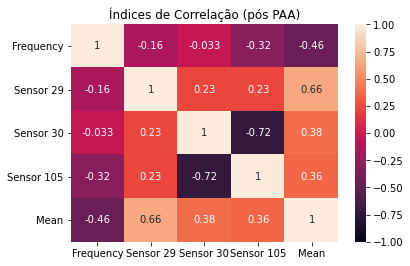

In [169]:
features = ['Frequency', 'Sensor 29',  'Sensor 30', 'Sensor 105', 'Mean']
plot_corr(zip(paa_buxco[0], paa_29[0], paa_30[0], paa_105[0], paa_media[0]), features, 'Índices de Correlação (pós PAA)')


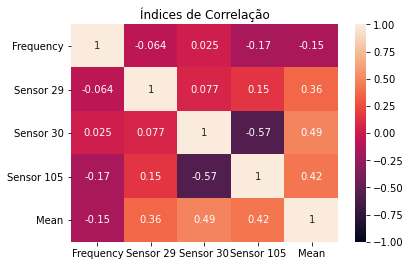

In [170]:
plot_corr(zip(df_buxco.frequency, processed_sensor_29, processed_sensor_30, processed_sensor_105, processed_sensors_mean), features, 'Índices de Correlação')